## Taxi Tip Prediction using Scikit-Learn and Snap ML

The dataset includes information about taxi tip and was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). We will use the trained model to predict the amount of tip paid.

Snap ML is a high-performance IBM library for ML modeling. It provides highly-efficient CPU/GPU implementations of linear models and tree-based models

## Objectives

1. Perform basic data preprocessing using Scikit-Learn
2. Model a regression task using the Scikit-Learn and Snap ML Python APIs
3. Train a Decision Tree Regressor model using Scikit-Learn and Snap ML
4. Run inference and assess the quality of the trained models

## Table of Content

1. Introduction
2. Import Libraries
3. Dataset Analysis
4. Dataset Preprocessing
5. Dataset Train/Test Split
6. Build a Decision Tree Regressor model with Scikit-Learn
7. Build a Decision Tree Regressor model with Snap ML
8. Evaluate the Scikit-Learn and Snap ML Decision Tree Regressors

## 1. INTRODUCTION

The dataset used in this exercise session is publicly available here: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page (all rights reserved by Taxi & Limousine Commission(TLC), City of New York). The TLC Yellow Taxi Trip Records of June, 2019 are used in this notebook. The prediction of the tip amount can be modeled as a regression problem. To train the model you can use part of the input dataset and the remaining data can be used to assess the quality of the trained model. First, let's download the dataset.

## 2. Import libraries

Let's install and import required libraries.
Note; I'm using python 3.7.9

In [35]:
!pip3 install snapml

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [90]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

## 3. Data Analysis

This dataset is too large for github, so we reduce to 10k records

In [93]:
!pip3 install pandas requests

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [95]:
import csv
import requests
from io import StringIO

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv"
output_file = "smaller_yellow_tripdata.csv"
num_rows = 10000

response = requests.get(url, stream=True)
response.raise_for_status()  # Raise an exception if the request was unsuccessful

csv_data = StringIO()

# Stream the first 10,000 rows (excluding the header) from the CSV file
num_lines = 0
for chunk in response.iter_lines(decode_unicode=True):
    if num_lines > num_rows:
        break
    csv_data.write(chunk + "\n")
    num_lines += 1

csv_data.seek(0)  # Move the file pointer back to the beginning of the StringIO object

# Read the CSV data using pandas
df = pd.read_csv(csv_data)

# Save the data to a new CSV file
df.to_csv(output_file, index=False)


In [97]:
# Set pandas display options for better readability
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

# Load data (assuming the data is in a .csv file)
raw_data = pd.read_csv('smaller_yellow_tripdata.csv')

# Records and features count
print("There are " + str(len(raw_data)) + " observations in the dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

raw_data.head(9)

There are 9979 observations in the dataset.
There are 18 variables in the dataset.


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1,0.0,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1,0.0,1,N,262,263,2,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1,4.4,1,N,74,7,2,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0,0.8,1,N,145,145,2,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1,1.7,1,N,113,148,1,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2,1.6,1,N,79,125,1,9.5,3.0,0.5,1.00,0.0,0.3,14.30,2.5
6,1,2019-06-01 00:46:46,2019-06-01 00:50:55,4,0.6,1,N,211,148,2,4.5,3.0,0.5,0.00,0.0,0.3,8.30,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2,1.2,1,N,79,249,1,7.5,3.0,0.5,1.00,0.0,0.3,12.30,2.5
8,1,2019-06-01 00:09:57,2019-06-01 00:25:54,2,2.0,1,N,158,68,2,11.5,3.0,0.5,0.00,0.0,0.3,15.30,2.5


Each row in the dataset represents a taxi trip. 
As shown above, each row has 18 variables. 
One variable is called tip_amount and represents the target variable. 
Our objective will be to train a model that uses the other variables to predict the value of the tip_amount variable. 

Let's first clean the dataset and retrieve basic statistics about the target variable.

There are 7007 observations in the dataset.
There are 17 variables in the dataset.


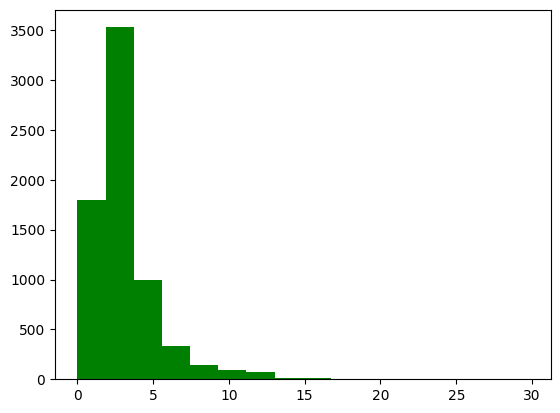

Minimum amount value is  0.01
Maximum amount value is  29.75
90% of the trips have a tip amount less or equal than  5.56


In [98]:
# some trips report 0 tip. it is assumed that these tips were paid in cash.
# for this study we drop all these rows
raw_data = raw_data[raw_data['tip_amount'] > 0]

# we also remove some outliers, namely those where the tip was larger than the fare cost
raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]

# we remove trips with very large fare cost
raw_data = raw_data[((raw_data['fare_amount'] >= 2) & (raw_data['fare_amount'] < 200))]

# we drop variables that include the target variable in it, i.e. the total_amount
clean_data = raw_data.drop(['total_amount'], axis=1)

# release memory occupied by raw_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del raw_data
gc.collect()

# print the number of trips left in the dataset
print("There are " + str(len(clean_data)) + " observations in the dataset.")
print("There are " + str(len(clean_data.columns)) + " variables in the dataset.")

# Let's visualize our data in a histogram
plt.hist(clean_data.tip_amount.values, 16, histtype='bar', facecolor='g')
plt.show()

print("Minimum amount value is ", np.min(clean_data.tip_amount.values))
print("Maximum amount value is ", np.max(clean_data.tip_amount.values))
print("90% of the trips have a tip amount less or equal than ", np.percentile(clean_data.tip_amount.values, 90))

Let's see what our clean data looks like!

In [99]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7007 entries, 4 to 9978
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               7007 non-null   int64  
 1   tpep_pickup_datetime   7007 non-null   object 
 2   tpep_dropoff_datetime  7007 non-null   object 
 3   passenger_count        7007 non-null   int64  
 4   trip_distance          7007 non-null   float64
 5   RatecodeID             7007 non-null   int64  
 6   store_and_fwd_flag     7007 non-null   object 
 7   PULocationID           7007 non-null   int64  
 8   DOLocationID           7007 non-null   int64  
 9   payment_type           7007 non-null   int64  
 10  fare_amount            7007 non-null   float64
 11  extra                  7007 non-null   float64
 12  mta_tax                7007 non-null   float64
 13  tip_amount             7007 non-null   float64
 14  tolls_amount           7007 non-null   float64
 15  impr

In [100]:
clean_data.head(9)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1,1.70,1,N,113,148,1,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2,1.60,1,N,79,125,1,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2,1.20,1,N,79,249,1,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1,8.60,1,N,186,243,1,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1,1.74,1,N,107,148,1,11.0,0.5,0.5,2.96,0.0,0.3,2.5
12,2,2019-06-01 00:33:26,2019-06-01 00:39:18,1,1.20,1,N,137,170,1,6.0,0.5,0.5,2.45,0.0,0.3,2.5
13,1,2019-06-01 00:01:42,2019-06-01 00:06:14,1,0.70,1,N,229,141,1,5.5,3.0,0.5,1.70,0.0,0.3,2.5
14,2,2019-06-01 00:20:08,2019-06-01 00:28:56,1,1.83,1,N,113,161,1,8.0,0.5,0.5,1.00,0.0,0.3,2.5
15,2,2019-06-01 00:30:40,2019-06-01 01:08:12,1,5.11,1,N,230,229,1,25.0,0.5,0.5,7.20,0.0,0.3,2.5


By looking at the dataset in more detail, we see that it contains information such as pick-up and drop-off dates/times, pick-up and drop-off locations, payment types, driver-reported passenger counts etc. Before actually training a ML model, we will need to preprocess the data. We need to transform the data in a format that will be correctly handled by the models. For instance, we need to encode the categorical features.

## 4. Data preprocessing

Let's prepare our data for training!

In [101]:
# Lets convert to pd datetine format

clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])

In [102]:
# Let's extract pickup and dropoff hour

clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

In [103]:
# extract pickup and dropoff day of week

clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

In [104]:
# compute trip time in minutes

clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).astype('timedelta64[m]')

In [105]:
clean_data.shape

(7007, 22)

Let's drop off the pickup and dropoff datetimes

In [106]:
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

# Time for one-hot-enodingcode

Some features are categorical, we need to encode them
To encode them we use one-hot encoding from the Pandas package

In [107]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7007 entries, 4 to 9978
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               7007 non-null   int64  
 1   passenger_count        7007 non-null   int64  
 2   trip_distance          7007 non-null   float64
 3   RatecodeID             7007 non-null   int64  
 4   store_and_fwd_flag     7007 non-null   object 
 5   PULocationID           7007 non-null   int64  
 6   DOLocationID           7007 non-null   int64  
 7   payment_type           7007 non-null   int64  
 8   fare_amount            7007 non-null   float64
 9   extra                  7007 non-null   float64
 10  mta_tax                7007 non-null   float64
 11  tip_amount             7007 non-null   float64
 12  tolls_amount           7007 non-null   float64
 13  improvement_surcharge  7007 non-null   float64
 14  congestion_surcharge   7007 non-null   float64
 15  pick

In [108]:
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(clean_data, columns=get_dummy_col)

proc_data

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,trip_time,VendorID_1,VendorID_2,VendorID_4,RatecodeID_1,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5,store_and_fwd_flag_N,store_and_fwd_flag_Y,PULocationID_4,PULocationID_7,PULocationID_10,PULocationID_12,PULocationID_13,PULocationID_17,PULocationID_24,PULocationID_25,PULocationID_33,PULocationID_36,PULocationID_40,PULocationID_41,PULocationID_42,PULocationID_43,PULocationID_45,PULocationID_48,PULocationID_49,PULocationID_50,PULocationID_52,PULocationID_61,PULocationID_65,PULocationID_66,PULocationID_68,PULocationID_74,PULocationID_75,PULocationID_79,PULocationID_80,PULocationID_87,PULocationID_88,PULocationID_90,PULocationID_97,PULocationID_100,PULocationID_106,PULocationID_107,PULocationID_112,PULocationID_113,PULocationID_114,PULocationID_116,PULocationID_119,PULocationID_125,PULocationID_127,PULocationID_129,PULocationID_132,PULocationID_134,PULocationID_137,PULocationID_138,PULocationID_140,PULocationID_141,PULocationID_142,PULocationID_143,PULocationID_144,PULocationID_145,PULocationID_146,PULocationID_148,PULocationID_151,PULocationID_152,PULocationID_158,PULocationID_161,PULocationID_162,PULocationID_163,PULocationID_164,PULocationID_166,PULocationID_170,PULocationID_179,PULocationID_181,PULocationID_186,PULocationID_189,PULocationID_190,PULocationID_193,PULocationID_194,PULocationID_195,PULocationID_209,PULocationID_211,PULocationID_217,PULocationID_220,PULocationID_223,PULocationID_224,PULocationID_226,PULocationID_229,PULocationID_230,PULocationID_231,PULocationID_232,PULocationID_233,PULocationID_234,PULocationID_236,PULocationID_237,PULocationID_238,PULocationID_239,PULocationID_243,PULocationID_244,PULocationID_246,PULocationID_249,PULocationID_255,PULocationID_256,PULocationID_257,PULocationID_260,PULocationID_261,PULocationID_262,PULocationID_263,PULocationID_264,PULocationID_265,DOLocationID_4,DOLocationID_7,DOLocationID_10,DOLocationID_12,DOLocationID_13,DOLocationID_14,DOLocationID_17,DOLocationID_18,DOLocationID_20,DOLocationID_21,DOLocationID_22,DOLocationID_24,DOLocationID_25,DOLocationID_29,DOLocationID_33,DOLocationID_34,DOLocationID_36,DOLocationID_37,DOLocationID_40,DOLocationID_41,DOLocationID_42,DOLocationID_43,DOLocationID_45,DOLocationID_47,DOLocationID_48,DOLocationID_49,DOLocationID_50,DOLocationID_51,DOLocationID_52,DOLocationID_54,DOLocationID_55,DOLocationID_56,DOLocationID_59,DOLocationID_61,DOLocationID_62,DOLocationID_64,DOLocationID_65,DOLocationID_66,DOLocationID_67,DOLocationID_68,DOLocationID_69,DOLocationID_70,DOLocationID_71,DOLocationID_72,DOLocationID_73,DOLocationID_74,DOLocationID_75,DOLocationID_76,DOLocationID_79,DOLocationID_80,DOLocationID_81,DOLocationID_82,DOLocationID_83,DOLocationID_85,DOLocationID_86,DOLocationID_87,DOLocationID_88,DOLocationID_89,DOLocationID_90,DOLocationID_92,DOLocationID_95,DOLocationID_97,DOLocationID_98,DOLocationID_100,DOLocationID_102,DOLocationID_106,DOLocationID_107,DOLocationID_112,DOLocationID_113,DOLocationID_114,DOLocationID_116,DOLocationID_117,DOLocationID_119,DOLocationID_120,DOLocationID_124,DOLocationID_125,DOLocationID_126,DOLocationID_127,DOLocationID_128,DOLocationID_129,DOLocationID_130,DOLocationID_131,DOLocationID_132,DOLocationID_133,DOLocationID_134,DOLocationID_135,DOLocationID_136,DOLocationID_137,DOLocationID_138,DOLocationID_139,DOLocationID_140,DOLocationID_141,DOLocationID_142,DOLocationID_143,DOLocationID_144,DOLocationID_145,DOLocationID_146,DOLocationID_148,DOLocationID_151,DOLocationID_152,DOLocationID_153,DOLocationID_157,DOLocationID_158,DOLocationID_159,DOLocationID_160,DOLocationID_161,DOLocationID_162,DOLocationID_163,DOLocationID_164,DOLocationID_165,DOLocationID_166,DOLocationID_168,DOLocationID_170,DOLocationID_171,DOLocationID_175,DOLocationID_177,DOLocationID_179,DOLocationID_180,DOLocationID_181,DOLocationID_182,DOLocationID_185,DOLocationID_186,DOLocationID_188,DOLocationID_189

# release memory occupied by clean_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory

In [109]:
del clean_data
gc.collect()

3988

In [110]:
proc_data

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,trip_time,VendorID_1,VendorID_2,VendorID_4,RatecodeID_1,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5,store_and_fwd_flag_N,store_and_fwd_flag_Y,PULocationID_4,PULocationID_7,PULocationID_10,PULocationID_12,PULocationID_13,PULocationID_17,PULocationID_24,PULocationID_25,PULocationID_33,PULocationID_36,PULocationID_40,PULocationID_41,PULocationID_42,PULocationID_43,PULocationID_45,PULocationID_48,PULocationID_49,PULocationID_50,PULocationID_52,PULocationID_61,PULocationID_65,PULocationID_66,PULocationID_68,PULocationID_74,PULocationID_75,PULocationID_79,PULocationID_80,PULocationID_87,PULocationID_88,PULocationID_90,PULocationID_97,PULocationID_100,PULocationID_106,PULocationID_107,PULocationID_112,PULocationID_113,PULocationID_114,PULocationID_116,PULocationID_119,PULocationID_125,PULocationID_127,PULocationID_129,PULocationID_132,PULocationID_134,PULocationID_137,PULocationID_138,PULocationID_140,PULocationID_141,PULocationID_142,PULocationID_143,PULocationID_144,PULocationID_145,PULocationID_146,PULocationID_148,PULocationID_151,PULocationID_152,PULocationID_158,PULocationID_161,PULocationID_162,PULocationID_163,PULocationID_164,PULocationID_166,PULocationID_170,PULocationID_179,PULocationID_181,PULocationID_186,PULocationID_189,PULocationID_190,PULocationID_193,PULocationID_194,PULocationID_195,PULocationID_209,PULocationID_211,PULocationID_217,PULocationID_220,PULocationID_223,PULocationID_224,PULocationID_226,PULocationID_229,PULocationID_230,PULocationID_231,PULocationID_232,PULocationID_233,PULocationID_234,PULocationID_236,PULocationID_237,PULocationID_238,PULocationID_239,PULocationID_243,PULocationID_244,PULocationID_246,PULocationID_249,PULocationID_255,PULocationID_256,PULocationID_257,PULocationID_260,PULocationID_261,PULocationID_262,PULocationID_263,PULocationID_264,PULocationID_265,DOLocationID_4,DOLocationID_7,DOLocationID_10,DOLocationID_12,DOLocationID_13,DOLocationID_14,DOLocationID_17,DOLocationID_18,DOLocationID_20,DOLocationID_21,DOLocationID_22,DOLocationID_24,DOLocationID_25,DOLocationID_29,DOLocationID_33,DOLocationID_34,DOLocationID_36,DOLocationID_37,DOLocationID_40,DOLocationID_41,DOLocationID_42,DOLocationID_43,DOLocationID_45,DOLocationID_47,DOLocationID_48,DOLocationID_49,DOLocationID_50,DOLocationID_51,DOLocationID_52,DOLocationID_54,DOLocationID_55,DOLocationID_56,DOLocationID_59,DOLocationID_61,DOLocationID_62,DOLocationID_64,DOLocationID_65,DOLocationID_66,DOLocationID_67,DOLocationID_68,DOLocationID_69,DOLocationID_70,DOLocationID_71,DOLocationID_72,DOLocationID_73,DOLocationID_74,DOLocationID_75,DOLocationID_76,DOLocationID_79,DOLocationID_80,DOLocationID_81,DOLocationID_82,DOLocationID_83,DOLocationID_85,DOLocationID_86,DOLocationID_87,DOLocationID_88,DOLocationID_89,DOLocationID_90,DOLocationID_92,DOLocationID_95,DOLocationID_97,DOLocationID_98,DOLocationID_100,DOLocationID_102,DOLocationID_106,DOLocationID_107,DOLocationID_112,DOLocationID_113,DOLocationID_114,DOLocationID_116,DOLocationID_117,DOLocationID_119,DOLocationID_120,DOLocationID_124,DOLocationID_125,DOLocationID_126,DOLocationID_127,DOLocationID_128,DOLocationID_129,DOLocationID_130,DOLocationID_131,DOLocationID_132,DOLocationID_133,DOLocationID_134,DOLocationID_135,DOLocationID_136,DOLocationID_137,DOLocationID_138,DOLocationID_139,DOLocationID_140,DOLocationID_141,DOLocationID_142,DOLocationID_143,DOLocationID_144,DOLocationID_145,DOLocationID_146,DOLocationID_148,DOLocationID_151,DOLocationID_152,DOLocationID_153,DOLocationID_157,DOLocationID_158,DOLocationID_159,DOLocationID_160,DOLocationID_161,DOLocationID_162,DOLocationID_163,DOLocationID_164,DOLocationID_165,DOLocationID_166,DOLocationID_168,DOLocationID_170,DOLocationID_171,DOLocationID_175,DOLocationID_177,DOLocationID_179,DOLocationID_180,DOLocationID_181,DOLocationID_182,DOLocationID_185,DOLocationID_186,DOLocationID_188,DOLocationID_189

Alright, time to get our independent (X) and dependent variables (y)

In [111]:
y = proc_data[['tip_amount']].values.astype('float32')
y

array([[2.65],
       [1.  ],
       [1.  ],
       ...,
       [0.01],
       [2.05],
       [2.06]], dtype=float32)

In [112]:
# drop the target variable from the feature matrix
proc_data = proc_data.drop(['tip_amount'], axis=1)

In [113]:
# get the feature matrix used for training
X = proc_data.values
X

array([[ 1. ,  1.7,  9.5, ...,  0. ,  1. ,  0. ],
       [ 2. ,  1.6,  9.5, ...,  0. ,  1. ,  0. ],
       [ 2. ,  1.2,  7.5, ...,  0. ,  1. ,  0. ],
       ...,
       [ 4. ,  2.1, 11.5, ...,  0. ,  1. ,  0. ],
       [ 2. ,  0.6,  4.5, ...,  0. ,  1. ,  0. ],
       [ 2. ,  1. ,  6.5, ...,  0. ,  1. ,  0. ]])

In [114]:
# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)
X

array([[0.02469136, 0.04197531, 0.2345679 , ..., 0.        , 0.02469136,
        0.        ],
       [0.05076142, 0.04060914, 0.24111675, ..., 0.        , 0.02538071,
        0.        ],
       [0.05714286, 0.03428571, 0.21428571, ..., 0.        , 0.02857143,
        0.        ],
       ...,
       [0.08350731, 0.04384134, 0.24008351, ..., 0.        , 0.02087683,
        0.        ],
       [0.07575758, 0.02272727, 0.17045455, ..., 0.        , 0.03787879,
        0.        ],
       [0.06289308, 0.03144654, 0.20440252, ..., 0.        , 0.03144654,
        0.        ]])

In [115]:
# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (7007, 325) y.shape= (7007, 1)


## 5. Dataset Train/Test Split

Now that the dataset is ready for building the classification models, we need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [117]:
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (4904, 325) Y_train.shape= (4904, 1)
X_test.shape= (2103, 325) Y_test.shape= (2103, 1)


## Build a Decision Tree Regressor model with Scikit-Learn

In [124]:
from sklearn.tree import DecisionTreeRegressor

# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)

# train a Decision Tree Regressor using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  0.06808


Build a Decision Tree Regressor model with Snap ML

In [62]:
# # import the Decision Tree Regressor Model from Snap ML
# from snapml import DecisionTreeRegressor

# # in contrast to sklearn's Decision Tree, Snap ML offers multi-threaded CPU/GPU training 
# # to use the GPU, one needs to set the use_gpu parameter to True
# # I will be using CPU
# # snapml_dt = DecisionTreeRegressor(max_depth=4, random_state=45, use_gpu=True)

# # to set the number of CPU threads used at training time, one needs to set the n_jobs parameter
# # for reproducible output across multiple function calls, set random_state to a given integer value
# snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)

# # train a Decision Tree Regressor model using Snap ML
# t0 = time.time()
# snapml_dt.fit(X_train, y_train)
# snapml_time = time.time()-t0
# print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

## 8. Evaluate the Scikit-Learn and Snap ML Decision Tree Regressors

In [126]:
from sklearn import metrics

y_pred = sklearn_dt.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


Mean Squared Error: 2.3062252878997773
Root Mean Squared Error: 1.51862611853602
Mean Absolute Error: 0.8483357426802333
R-squared: 0.5302913161651404
